<a href="https://colab.research.google.com/github/ykitaguchi77/pytorch-models/blob/master/AdaCos_classification1.1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Arcface-pytorch (AdaCos)
https://github.com/ronghuaiyang/arcface-pytorch/blob/master/models/metrics.py
Colabのスクリプト　https://cpp-learning.com/adacos/

In [0]:
import os
# import argparse
import numpy as np
import pandas as pd
import math
from tqdm import tqdm
import joblib
from collections import OrderedDict
 
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Parameter
import torch.backends.cudnn as cudnn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
import torchvision
import matplotlib.pyplot as plt

 
# from utils import *
# from mnist import archs
# import metrics

use_cuda = torch.cuda.is_available() and True
device = torch.device("cuda" if use_cuda else "cpu")

In [2]:
'''
フォルダ構成(※class名は4文字にすること)
---dataset.zip-----train-----appl
               |          |--stra
               |
               |---val-------appl
                          |--stra
'''


from google.colab import drive
drive.mount('/content/drive')

#dataset.zipを解凍

!date -R
!unzip -qq drive/My\ Drive/AI_laboratory_course/dataset.zip
!date -R
!ls

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
Tue, 21 Apr 2020 07:35:52 +0000
Tue, 21 Apr 2020 07:36:01 +0000
drive  sample_data  train  val


In [3]:
# 入力画像の前処理をするクラス
# 訓練時と推論時で処理が異なる

"""
    画像の前処理クラス。訓練時、検証時で異なる動作をする。
    画像のサイズをリサイズし、色を標準化する。
    訓練時はRandomResizedCropとRandomHorizontalFlipでデータオーギュメンテーションする。


    Attributes
    ----------
    resize : int
        リサイズ先の画像の大きさ。
    mean : (R, G, B)
        各色チャネルの平均値。
    std : (R, G, B)
        各色チャネルの標準偏差。
"""

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224, scale=(0.5,1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


data_dir = '/content'
train_set = datasets.ImageFolder(os.path.join(data_dir, 'train'),data_transforms['train'])
val_set = datasets.ImageFolder(os.path.join(data_dir, 'val'),data_transforms['val'])

train_loader = torch.utils.data.DataLoader(
        train_set,
        batch_size=20,
        shuffle=True,
        num_workers=4)
val_loader = torch.utils.data.DataLoader(
        val_set,
        batch_size=20,
        shuffle=False,
        num_workers=4)


#Print dataset detail
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

print(class_names)
k=0
for i in class_names:
    print(class_names[k]+"_train:"+str(len(os.listdir(path= data_dir + '/train/'+class_names[k]))))
    k+=1
k=0
for i in class_names:
    print(class_names[k]+"_val:"+str(len(os.listdir(path= data_dir + '/val/'+class_names[k]))))
    k+=1

print("training data set_total："+ str(len(image_datasets['train'])))
print("validating data set_total："+str(len(image_datasets['val'])))

['appl', 'stra']
appl_train:252
stra_train:252
appl_val:67
stra_val:60
training data set_total：504
validating data set_total：127


#少数の画像を可視化する

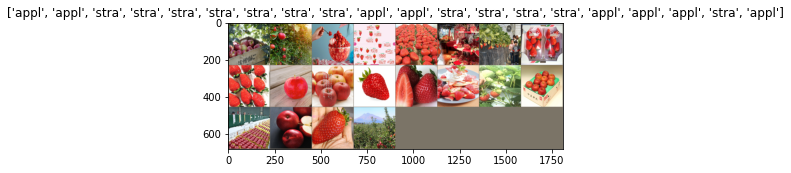

In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(train_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

#AdaCos class

In [0]:
class AdaCos(nn.Module):
    def __init__(self, num_features, num_classes, m=0.50):
        super(AdaCos, self).__init__()
        self.num_features = num_features
        # self.n_classes = num_classes
        self.s = math.sqrt(2) * math.log(num_classes - 1)
        self.m = m
        self.W = Parameter(torch.FloatTensor(num_classes, num_features))
        nn.init.xavier_uniform_(self.W)
 
    def forward(self, input, label):
        # normalize features
        x = F.normalize(input)
        # normalize weights
        W = F.normalize(self.W)
        # dot product
        logits = F.linear(x, W)
        # add margin
        theta = torch.acos(torch.clamp(logits, -1.0 + 1e-7, 1.0 - 1e-7))
        target_logits = torch.cos(theta + self.m)
        one_hot = torch.zeros_like(logits)
        one_hot.scatter_(1, label.view(-1, 1).long(), 1)
        output = logits * (1 - one_hot) + target_logits * one_hot
        # feature re-scale
        with torch.no_grad():
            B_avg = torch.where(one_hot < 1, self.s * torch.exp(logits), torch.zeros_like(logits))
            B_avg = torch.sum(B_avg) / input.size(0)
            # print(B_avg)
            theta_med = torch.median(theta)
            self.s = torch.log(B_avg) / torch.cos(torch.min(math.pi/4 * torch.ones_like(theta_med), theta_med))
        # print(self.s)
        output *= self.s
 
        return output

#平均値・Accuracy計算

In [0]:

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

#Train

In [0]:
def train(train_loader, model, metric_fc, criterion, optimizer):
    losses = AverageMeter()
    acc1s = AverageMeter()
 
    # switch to train mode
    model.train()
    metric_fc.train()
 
    for i, (input, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
        input = input.to(device)
        target = target.to(device)
 
        output = model(input)
        #feature = model(input)
        #output = metric_fc(feature, target)
        loss = criterion(output, target)
 
        acc1, = accuracy(output, target, topk=(1,))
 
        losses.update(loss.item(), input.size(0))
        acc1s.update(acc1.item(), input.size(0))
 
        # compute gradient and do optimizing step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
 
    log = OrderedDict([
        ('loss', losses.avg),
        ('acc1', acc1s.avg),
    ])
 
    return log

In [0]:
def train(train_loader, model, metric_fc, criterion, optimizer):
    losses = AverageMeter()
    acc1s = AverageMeter()
 
    # switch to train mode
    model.train()
    metric_fc.train()
 
    for i, (input, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
        input = input.to(device)
        target = target.to(device)
 
        feature = model(input)
        output = metric_fc(feature, target)
        loss = criterion(output, target)
 
        acc1, = accuracy(output, target, topk=(1,))
 
        losses.update(loss.item(), input.size(0))
        acc1s.update(acc1.item(), input.size(0))
 
        # compute gradient and do optimizing step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
 
    log = OrderedDict([
        ('loss', losses.avg),
        ('acc1', acc1s.avg),
    ])
 
    return log

#Val

In [0]:
def validate(val_loader, model, metric_fc, criterion):
    losses = AverageMeter()
    acc1s = AverageMeter()

    # switch to evaluate mode
    model.eval()
    metric_fc.eval()

    with torch.no_grad():
        for i, (input, target) in tqdm(enumerate(val_loader), total=len(val_loader)):
            input = input.to(device)
            target = target.to(device)

            output = model(input)
            #feature = model(input)
            #output = metric_fc(feature, target)
            loss = criterion(output, target)

            acc1, = accuracy(output, target, topk=(1,))

            losses.update(loss.item(), input.size(0))
            acc1s.update(acc1.item(), input.size(0))

    log = OrderedDict([
        ('loss', losses.avg),
        ('acc1', acc1s.avg),
    ])

    return log

In [0]:
def validate(val_loader, model, metric_fc, criterion):
    losses = AverageMeter()
    acc1s = AverageMeter()

    # switch to evaluate mode
    model.eval()
    metric_fc.eval()

    with torch.no_grad():
        for i, (input, target) in tqdm(enumerate(val_loader), total=len(val_loader)):
            input = input.to(device)
            target = target.to(device)

            feature = model(input)
            output = metric_fc(feature, target)
            loss = criterion(output, target)

            acc1, = accuracy(output, target, topk=(1,))

            losses.update(loss.item(), input.size(0))
            acc1s.update(acc1.item(), input.size(0))

    log = OrderedDict([
        ('loss', losses.avg),
        ('acc1', acc1s.avg),
    ])

    return log

#Define the Early Stopping Class

#Connect instances from between Model and metric_fc

In [0]:
model_ft = models.resnet18(pretrained = False)
#num_ftrs = model_ft.fc.in_features
#model_ft.fc = nn.Linear(num_ftrs, 2)

#GPU使用
model_ft = model_ft.to(device)

#AdaCosと結合
num_features = model_ft.fc.out_features
metric_fc = AdaCos(num_features, num_classes=2).to(device)

#Set parameters

In [0]:
epochs = 10
 
optimizer = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
# optimizer = optim.Adam(model.parameters(), lr=0.02)
 
#scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[epoch//2, 3*epoch//4], gamma=0.1) 
#scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-3)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

criterion = nn.CrossEntropyLoss().to(device)


#Start learning

In [0]:
log = pd.DataFrame(index=[],
                   columns=[ 'epoch', 'lr', 'loss', 'acc1', 'val_loss', 'val_acc1'])
best_loss = float('inf')
 
for epoch in range(epochs):
    print('Epoch [%d/%d]' %(epoch+1, epochs))
 
    scheduler.step()
 
    # train for one epoch
    train_log = train(train_loader, model_ft, metric_fc, criterion, optimizer)
    # evaluate on validation set
    val_log = validate(val_loader, model_ft, metric_fc, criterion)
    print('\nepoch {}, lr: {}' .format(epoch+1, scheduler.get_lr()[0]))
    print('train_Loss %.4f  Acc1 %.4f  \nval_Loss   %.4f  Acc %.4f'
            %(train_log['loss'], train_log['acc1'], val_log['loss'], val_log['acc1']))
 
    tmp = pd.Series([
            epoch,
            scheduler.get_lr()[0],
            train_log['loss'],
            train_log['acc1'],
            val_log['loss'],
            val_log['acc1'],
        ], index=['epoch', 'lr', 'loss', 'acc1', 'val_loss', 'val_acc1'])
 
    log = log.append(tmp, ignore_index=True)
    log.to_csv('models_log.csv', index=False)
 
    if val_log['loss'] < best_loss:
        torch.save(model_ft.state_dict(), 'model.pth')
        best_loss = val_log['loss'] 
        print("> saved best model")

Epoch [1/10]


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:122: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
100%|██████████| 7/7 [00:01<00:00,  3.57it/s]


epoch 1, lr: 0.001
train_Loss nan  Acc1 2.1825  
val_Loss   nan  Acc 0.0000
Epoch [2/10]



100%|██████████| 7/7 [00:01<00:00,  3.59it/s]


epoch 2, lr: 0.001
train_Loss nan  Acc1 1.7857  
val_Loss   nan  Acc 0.0000
Epoch [3/10]



100%|██████████| 7/7 [00:01<00:00,  3.54it/s]


epoch 3, lr: 0.001
train_Loss nan  Acc1 0.0000  
val_Loss   nan  Acc 0.0000
Epoch [4/10]



100%|██████████| 7/7 [00:01<00:00,  3.58it/s]


epoch 4, lr: 0.001
train_Loss nan  Acc1 0.0000  
val_Loss   nan  Acc 0.0000
Epoch [5/10]



100%|██████████| 7/7 [00:01<00:00,  3.53it/s]


epoch 5, lr: 0.001
train_Loss nan  Acc1 2.1825  
val_Loss   nan  Acc 0.0000
Epoch [6/10]



100%|██████████| 7/7 [00:01<00:00,  3.60it/s]


epoch 6, lr: 0.001
train_Loss nan  Acc1 2.3810  
val_Loss   nan  Acc 0.0000
Epoch [7/10]



 19%|█▉        | 5/26 [00:03<00:14,  1.43it/s]

In [12]:
# visualize the loss as the network trained
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
plt.plot(range(1,len(valid_loss)+1),valid_loss,label='Validation Loss')

# find position of lowest validation loss
minposs = valid_loss.index(min(valid_loss))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim(0, 0.5) # consistent scale
plt.xlim(0, len(train_loss)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('loss_plot.png', bbox_inches='tight')

NameError: ignored

<Figure size 720x576 with 0 Axes>